In [9]:
from astromodule.table import crossmatch, radial_search
from pylegs.io import read_table, write_table
from sklearn.decomposition import PCA
from sklearn.cluster import HDBSCAN
from matplotlib import pyplot as plt
from astropy.coordinates import SkyCoord
from astropy import units as u
import numpy as np
import umap
import seaborn as sns

In [ ]:
# center = SkyCoord(ra=18.74049, dec=0.43756, unit=u.deg)
# df_vis = radial_search(center, '/mnt/hd/natanael/astrodata/representations_pca_40_with_coords.parquet', radius=1.488*u.deg)
# df_match = crossmatch('/home/natan/Downloads/A168.parquet', df_vis)
df_match = read_table('/mnt/hd/natanael/astrodata/A194+emb.parquet')

In [ ]:
def plot(
  table, 
  min_cluster_size=4, 
  angular_rp_forest=True, 
  epochs=None,
  lr=1.0,
  n_neighbors=15,
  out=None
):
  df_match = read_table(table)
  
  features = df_match.loc[:, 'feat_pca_0':'feat_pca_19']

  # features = features @ features.T
  hdb = HDBSCAN(min_cluster_size=min_cluster_size, metric='cosine')
  hdb.fit(features)
  lbl = hdb.labels_
  df_match['hdbscan_class'] = lbl
  
  pca = PCA(n_components=2, n_oversamples=10)
  pca.fit(features)
  X = pca.transform(features)

  mask = lbl != -1
  mask = [True]*len(df_match)
  reducer = umap.UMAP(
    n_components=2, 
    metric='cosine', 
    random_state=42, 
    angular_rp_forest=angular_rp_forest,
    n_epochs=epochs,
    n_neighbors=n_neighbors,
    learning_rate=lr,
    
  )
  X = reducer.fit_transform(features[mask])
  df_match = df_match[df_match.hdbscan_class != -1].reset_index(drop=True)
  df_match['umap_0'] = X[:, 0]
  df_match['umap_1'] = X[:, 1]

  sns.scatterplot(
    df_match, 
    x='umap_0', 
    y='umap_1', 
    hue='hdbscan_class',
    size=4, 
    palette=sns.color_palette('hls', 28, as_cmap=True), 
    legend=False
  )

  print(np.unique(lbl))
  
  if out:
    write_table(df_match, out)

/home/natan/.local/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/tmp/ipykernel_1692557/2903151287.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_match['umap_0'] = X[:, 0]
/tmp/ipykernel_1692557/2903151287.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_match['umap_1'] = X[:, 1]


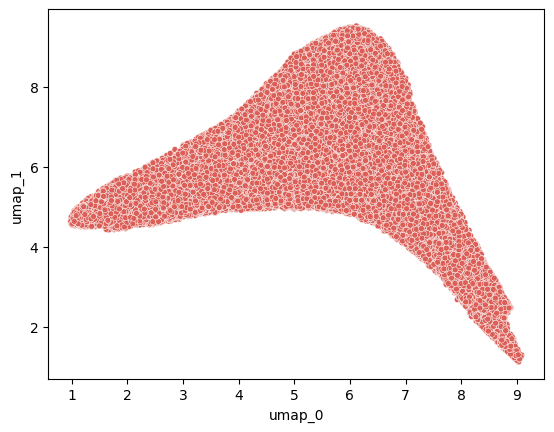

In [ ]:
plot(
  df_match,
  min_cluster_size=5, 
  epochs=1200,
  lr=0.0001,
  n_neighbors=22,
  angular_rp_forest=True,
  # out='/mnt/hd/natanael/astrodata/A194+emb+umap.parquet'
)